# Recipe2Cuisine

Data Challenge: July 19, 2020
Candidate: Isaac Chung\
Time alloted: 4 hours\
Task: 1) Design and execute a method to predict the cuisine of a recipe given only its ingredients. How could you design this to be robust enough to understand similarities / substitutions between ingredients? 2) For each each major cuisine, what are the driving ingredients that characterize it?

Your product manager indicates a likelihood that you will only need to write a guideline for an outsourced team to hand label the remaining corpus. 3) How would you go about writing this guide for a few major cuisines?

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## 0. Import data
First let's import the data set, and see what's inside. Data is given in a json file. Let's use pandas' read_json function.

In [2]:
data = pd.read_json("recipies.json") 

We have cuisine as class labels, and list of ingredients for each recipe id. 

In [3]:
data.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


## 1. Initial Data Analysis:
1. Data set shape, types
2. NaN values
3. Duplicates

### 1.1 Data set shape and types
Let's see what the shape and type of the data we have. We are working with just under 40,000 recipes. It does not seem like there are missing values.

In [4]:
print(data.shape)
print(data.info())

(39774, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None


### 1.2 Check for NaN values
Looks good so far.

In [5]:
data.isna().sum()

id             0
cuisine        0
ingredients    0
dtype: int64

### 1.3 Check for duplicate values
Looks good as well!

In [6]:
data.id.duplicated().sum()

0

Let's drop the id column as its use is complete.

In [7]:
data.drop(columns='id', inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   cuisine      39774 non-null  object
 1   ingredients  39774 non-null  object
dtypes: object(2)
memory usage: 621.6+ KB


## 2. Exploratory Data Analysis

### 2.1 Cuisine counts
There are 20 classes, and they are imbalanced. Italian and Mexican cuisines are the top two majority classes.

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64


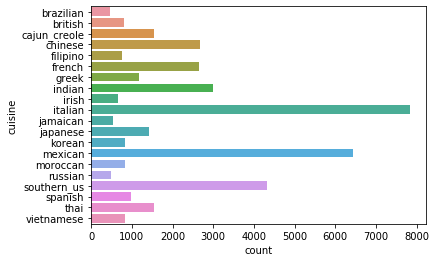

In [9]:
print(data.cuisine.value_counts())
sns.countplot(y=data.cuisine.sort_values())

### 2.2 Ingredients frequency
Now let's find out how often these ingredients are used in the recipes. Let's define a master ingredients list. The following method might not be the most optimal, but it gets the job done for now. Then let's see the top 20 ingredients across all cruisines.

In [10]:
ingredient_list = list()
for index, row in data.iterrows():
    ingredient_list.extend(row['ingredients'])

In [11]:
glist = pd.Series(ingredient_list, dtype=str)

We can pick out quickly the top 20 most frequently used ingredients include variants of salt and water. These ingredients are most likely not informative for predicting cuisines. Note that the presence of olive oil might suggest some bias towards italian cooking.

In [12]:
glist.value_counts().head(20)

salt                   18049
olive oil               7972
onions                  7972
water                   7457
garlic                  7380
sugar                   6434
garlic cloves           6237
butter                  4848
ground black pepper     4785
all-purpose flour       4632
pepper                  4438
vegetable oil           4385
eggs                    3388
soy sauce               3296
kosher salt             3113
green onions            3078
tomatoes                3058
large eggs              2948
carrots                 2814
unsalted butter         2782
dtype: int64

We can also look at the least frequently used ingredients. Looks like the ingredients below are only mentioned once, in one recipe. There are some brand names included, which might not be something we want to encode, e.g. "Soy Vay® Veri Veri Teriyaki®", "DeLallo", and "KRAFT". This is because these ingredients may be recipe-specific, but not cuisine-specific, meaning they might not all be representative of what the cuisines are generally composed of.

In [13]:
glist.value_counts(ascending=True).head(20)

ogura-an                                               1
cappuccino                                             1
darjeeling tea leaves                                  1
Classico Pasta Sauce                                   1
Bertolli® Arrabbiata Sauce                             1
ascorbic acid                                          1
sushi vinegar                                          1
morcilla                                               1
mushroom broth                                         1
nonfat italian dressing                                1
Foster Farms boneless skinless chicken breasts         1
marrons                                                1
Old El Paso™ mild red enchilada sauce                  1
fuji apples                                            1
uni                                                    1
alaskan king salmon                                    1
squash seeds                                           1
shrimp chips                   

Moving forward, we could treat the minimum frequency of ingredients as a tunable hyperparameter. Here I am choosing 1% of the 2nd and 3rd  most frequent counts (79). Given more time, I would write a custom class to implement the fit method for this to be in a sklearn pipeline.

In [14]:
min_freq = 79
mask = glist.isin(glist.value_counts()[glist.value_counts() > min_freq].index)
glist = glist[mask]

### 2.3 Ingredients count
We can count the number of ingredients per recipe, and see the distributions of counts across cuisines.

In [15]:
data['num_in'] = data.ingredients.map(lambda x: len(x))

In [16]:
data.groupby(['cuisine'])['num_in'].describe()

,count,mean,std,min,25%,50%,75%,max
cuisine,,,,,,,,
brazilian,467.0,9.520343,5.555139,2.0,5.0,9.0,13.0,59.0
british,804.0,9.708955,4.165011,2.0,7.0,9.0,12.0,30.0
cajun_creole,1546.0,12.617076,4.611601,2.0,9.0,12.0,16.0,31.0
chinese,2673.0,11.982791,4.042125,2.0,9.0,12.0,14.0,38.0
filipino,755.0,10.000000,3.855135,2.0,7.0,10.0,12.0,38.0
french,2646.0,9.817838,4.144744,1.0,7.0,9.0,12.0,31.0
greek,1175.0,10.182128,3.729461,1.0,7.0,10.0,12.0,27.0
indian,3003.0,12.705961,5.016806,1.0,9.0,12.0,16.0,49.0
irish,667.0,9.299850,3.700505,2.0,7.0,9.0,12.0,27.0


We could also visualize these results on a boxplot. Note that the horizontal line shown in the boxes are medians.

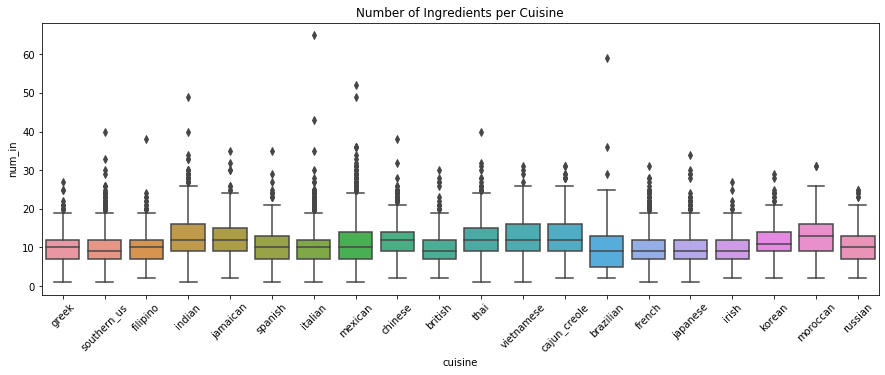

In [17]:
plt.figure(figsize=(15,5))
plt.title('Number of Ingredients per Cuisine')
ax = sns.boxplot(x="cuisine", y="num_in", data=data)
plt.xticks(rotation=45)
plt.show()

In [18]:
def join_list(text_list):
    return " ".join(text_list)

In [19]:
data['joined'] = data['ingredients'].apply(join_list)

In [20]:
data.head()

,cuisine,ingredients,num_in,joined
0,greek,"[romaine lettuce, black olives, grape tomatoes...",9,romaine lettuce black olives grape tomatoes ga...
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,plain flour ground pepper salt tomatoes ground...
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,eggs pepper salt mayonaise cooking oil green c...
3,indian,"[water, vegetable oil, wheat, salt]",4,water vegetable oil wheat salt
4,indian,"[black pepper, shallots, cornflour, cayenne pe...",20,black pepper shallots cornflour cayenne pepper...


## 3. Feature Engineering
We have some ingredients that are shared among cuisines, and some ingredients that are unique to some cuisines.  Since the list of ingredients can be read in no particular order (word order does not matter), we can get a bag-of-words (BOW) model. I am opting for a simple method by using TF-IDF.

From [tfidf.com](http://www.tfidf.com/), "Tf-idf stands for term frequency-inverse document frequency. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus." Here our recipes would be our 'documents'.

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

We want to convert all text to lowercase. Scikit-learn's TfidfVectorizer, which is equivalent to applying the CountVectorizer followed by TfidfTransformer, can do this as well. We can use the default options. As for the vocabulary, using the ingredients frequency results, we should drop 'salt' and 'water'. 

In [22]:
glist.count()

367999

In [23]:
glist = glist[~glist.isin(['salt','water'])]
glist.count()

342493

We want the BOW model to include unique vocabularies from the corpus.

In [24]:
unique_vocab = glist.drop_duplicates().tolist()
vectorizer = TfidfVectorizer(min_df=5, vocabulary=unique_vocab)
t_matrix = vectorizer.fit_transform(data.joined).toarray()

In [25]:
len(vectorizer.vocabulary_)

729

In [26]:
t_matrix.shape

(39774, 729)

In [27]:
t_matrix.dtype

dtype('float64')

We have quite a large matrix on hand. It is using 64bits (8 bytes) x 39774 x 729 = 221 MB.\
One way to reduce this dimension is to do some more cleaning using the earlier studies regarding ingredient frequencies and number of ingredients per recipe.

## 4. Modeling 

### 4.1 Naive Bayes
NB is a common model used for text classification. Here a strong assumption is made where the features are conditionally independent given the class label. Before we load the model, we should encode the class labels, and split the data into train-test splits (80-20). 

Note that *multinomial NB* should be used here since we are dealing with discrete variables. Gaussian NB is more suitable for continuous variables which probabilities can be modeled using a Gaussian distribution. 

In [28]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data['encoded'] = encoder.fit_transform(data.cuisine)
data.head()

,cuisine,ingredients,num_in,joined,encoded
0,greek,"[romaine lettuce, black olives, grape tomatoes...",9,romaine lettuce black olives grape tomatoes ga...,6
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,plain flour ground pepper salt tomatoes ground...,16
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,eggs pepper salt mayonaise cooking oil green c...,4
3,indian,"[water, vegetable oil, wheat, salt]",4,water vegetable oil wheat salt,7
4,indian,"[black pepper, shallots, cornflour, cayenne pe...",20,black pepper shallots cornflour cayenne pepper...,7


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(t_matrix, data.encoded, test_size=0.2, stratify=data.encoded)

In [30]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB().fit(X_train, y_train)

#### Model Validation
We can first look at the accuracy scores.

In [31]:
from sklearn.metrics import accuracy_score

y_pred_mnb = mnb.predict(X_test)
accuracy_mnb = accuracy_score(y_test, y_pred_mnb)
print("Accuracy MNB: %.2f%%" % (accuracy_mnb * 100.0))

Accuracy MNB: 59.90%


### 4.2 Support Vector Machine
SVM is another common model for text classification. Let's start with the linear kernel.

In [32]:
from sklearn.svm import LinearSVC
svc = LinearSVC().fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print("Accuracy SVC: %.2f%%" % (accuracy_svc * 100.0))

Accuracy SVC: 66.12%


## [Edit]
Special thanks for Chris Kimber's explanation.
## 5. Improved text preprocessing
The plain text seems to be having troubles breaking the 70% mark. I suspect that the model themselves are as good as the input data that's fed into them. We must now clean the data properly. I will try using NLTK next.

In [33]:
ingredients = data.ingredients.copy()

Here the puncutation and numbers are removed, and all letters are converted to lowercase. The text is then tokenized by vectorizing the text corpus. 

In [34]:
import re
import nltk
nltk.download('punkt')
nltk.download('averaged_perception_tagger')
from nltk.tokenize import word_tokenize

def clean(text):
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text) #remove website related syntax
    text = re.sub("[^a-zA-Z ]", "", text) #retain only letters
    text = text.lower() #lowercase text
    text = word_tokenize(text)
    return text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chung\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading averaged_perception_tagger: Package
[nltk_data]     'averaged_perception_tagger' not found in index


In [35]:
ingredients = [[clean(entry) for entry in recipe] for recipe in ingredients]
ingredients[:2]

[[['romaine', 'lettuce'],
  ['black', 'olives'],
  ['grape', 'tomatoes'],
  ['garlic'],
  ['pepper'],
  ['purple', 'onion'],
  ['seasoning'],
  ['garbanzo', 'beans'],
  ['feta', 'cheese', 'crumbles']],
 [['plain', 'flour'],
  ['ground', 'pepper'],
  ['salt'],
  ['tomatoes'],
  ['ground', 'black', 'pepper'],
  ['thyme'],
  ['eggs'],
  ['green', 'tomatoes'],
  ['yellow', 'corn', 'meal'],
  ['milk'],
  ['vegetable', 'oil']]]

Next, the parts of speech (POS) are tagged. Here we want to filter out most action verbs / instruction related adjectives (e.g. diced/sliced), but keep some descriptive words that are part of the core ingredient (e.g. baking soda). 
Here the following POS are excluded: check this [link](https://cs.nyu.edu/grishman/jet/guide/PennPOS.html)\
'VB': verb base, 'VBD': verb simple past, 'VBN': verb past participle, 'VBP': verb present tense, 'VBZ': verb 3rd singlar present, 'CC': Coordinating conjunction. 

Rading a tagged corpus involves reading tuples of ([word],[tag]). From here the preprocess steps follow exactly like Chris' notebook on the same topic.

In [36]:
ingredients_tagged = [[nltk.pos_tag(entry) for entry in recipe] for recipe in ingredients]
excluded_tags = ['VB', 'VBD', 'VBN', 'VBP', 'VBZ', 'CC']
ingredients_filtered = [[[t for t in tags if t[1] not in excluded_tags] for tags in recipe]for recipe in ingredients_tagged]

The next step is to convert plural nouns and plural proper nouns to their singular counterparts. To achieve this, the lemmatizer is used on the words with 'NNS' and 'NNPS' POS tags.

In [37]:
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def singular_nouns(t):
    if t[1] in ['NNPS', 'NNS']:
        return lemmatizer.lemmatize(t[0], pos = 'n')
    else:
        return t[0]

ingredients_filtered = [[[singular_nouns(t) for t in tags] for tags in recipe] for recipe in ingredients_filtered]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chung\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The final part of the cleaning involves removing stop words. These words are deemed to give no additional meaning to our purpose and appear quite frequently. Example of common stop words are articles like 'the', 'an', and 'a'. Here we choose a specific list of stop words for cooking. Thanks to Chris' Insight project, he already has a curated list.

In [38]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

ingredients_filtered = [[[w for w in entry if not w in stop_words] for entry in recipe] for recipe in ingredients_filtered]

# Omit weights and measures
blacklist = ['ounce', 'ounces', 'cups', 'cup', 'teaspoon', 'tablespoon', 'tablespoons', 'teaspoons', 'c', 'g', 'v', 'tbsp', 'x', 'ml', 'lb', 'tbs', 'oz', 'pkg', 'large', 'small', 'tsp', 'inch', 'grams', 'quarts', 'lbs', 'can', 'cube', 'whole', 'or', 'pieces', 'piece', 'chopped', 'shredded', 'diced', 'fresh', 'crushed', 'tsp', 'package', 'kg', 'kilogram', 'gallon', 'degree', 'degrees', 'temperature', 'hot', 'warm', 'cold', 'boiling', 'lukewarm', 'f', 'c','slice', 'sliced', 'fresh', 'freshly', 'pound', 'pounds', 'thin', 'thinly', 'thick', 'thickly', 'coarsely', 'finely', 'jar', 'strip', 'strips', 'cut', 'peeled', 'wedge', 'bitesize', 'according', 'direction', 'optional', 'bite', 'size', 'half', 'pinch', 'dash', 'eg', 'frozen', 'thawed', 'recipe', 'fat', 'quart', 'quarts', 'pint', 'pints', 'splash', 'container', 'fried', 'cooked', 'uncooked', 'boiled', 'reduced', 'drained', 'water', 'one', 'washed', 'rinsed', 'pitted', 'head', 'tube', 'fluid', 'fl', 'preferably', 'bottle', 'diagonally', 'crosswise', 'lengthwise', 'torn', 'serving', 'bunch', 'halved', 'part', 'quartered', 'available', 'grocery', 'first', 'andor', 'substitution', 'bar']
ingredients_clean = [[[w for w in entry if not w in blacklist] for entry in recipe] for recipe in ingredients_filtered]

# Omit brands
substrings = ['®', '™']
ingredients_clean = [[[w for w in entry if not any(x in w for x in substrings)] for entry in recipe] for recipe in ingredients_clean]

# Remove empty lists
ingredients_clean = [[entry for entry in recipe if entry != [] ]for recipe in ingredients_clean]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chung\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


To recap, we have a master list of recipes, which contains lists of ingredients as lists. The final layer of lists represents the n-grams of ingredients. The final step here is to join these n-grams with underscores, and join these individial ingredients lists back to one list.

In [39]:
ingredients_clean[:2]

[[['romaine', 'lettuce'],
  ['black', 'olive'],
  ['grape', 'tomato'],
  ['garlic'],
  ['pepper'],
  ['purple', 'onion'],
  ['seasoning'],
  ['garbanzo', 'bean'],
  ['feta', 'cheese', 'crumbles']],
 [['plain', 'flour'],
  ['ground', 'pepper'],
  ['salt'],
  ['tomato'],
  ['ground', 'black', 'pepper'],
  ['thyme'],
  ['egg'],
  ['green', 'tomato'],
  ['yellow', 'corn', 'meal'],
  ['milk'],
  ['vegetable', 'oil']]]

In [40]:
ingredients_processed = [','.join(['_'.join(ingredient) for ingredient in recipe]) for recipe in ingredients_clean]

In [45]:
ingredients_processed[:5]

['romaine_lettuce, black_olive, grape_tomato, garlic, pepper, purple_onion, seasoning, garbanzo_bean, feta_cheese_crumbles',
 'plain_flour, ground_pepper, salt, tomato, ground_black_pepper, thyme, egg, green_tomato, yellow_corn_meal, milk, vegetable_oil',
 'egg, pepper, salt, mayonaise, cooking_oil, green_chilies, chicken_breast, garlic_powder, yellow_onion, soy_sauce, butter, chicken_liver',
 'vegetable_oil, wheat, salt',
 'black_pepper, shallot, cornflour, cayenne_pepper, onion, garlic_paste, milk, butter, salt, lemon_juice, chili_powder, passata, oil, ground_cumin, boneless_chicken_skinless_thigh, garam_masala, double_cream, natural_yogurt, bay_leaf']

In [46]:
len(ingredients_processed)

39774

## 6. New models with improved preprocessed text


In [50]:
X = ingredients_processed
y = data.cuisine
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
vectorizer = TfidfVectorizer(min_df = 5)
vectorizer.fit(X_train)
X_train_t = vectorizer.transform(X_train)
X_test_t = vectorizer.transform(X_test)
clf = MultinomialNB()
clf.fit(X_train_t, y_train)
y_pred = clf.predict(X_test_t)
accuracy = accuracy_score(y_pred, y_test)
print("Accuracy MNB with improved text: %.2f%%" % (accuracy * 100.0))

Accuracy MNB with improved text: 69.79%


Here Chris recommends trying the SGD classifier. 

In [52]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier()
clf.fit(X_train_t, y_train)
y_pred = clf.predict(X_test_t)
accuracy = accuracy_score(y_pred, y_test)
print("Accuracy MNB with improved text: %.2f%%" % (accuracy * 100.0))

Accuracy MNB with improved text: 77.16%


## 7. Insights
Let's extract some insight from the confusion matrix.

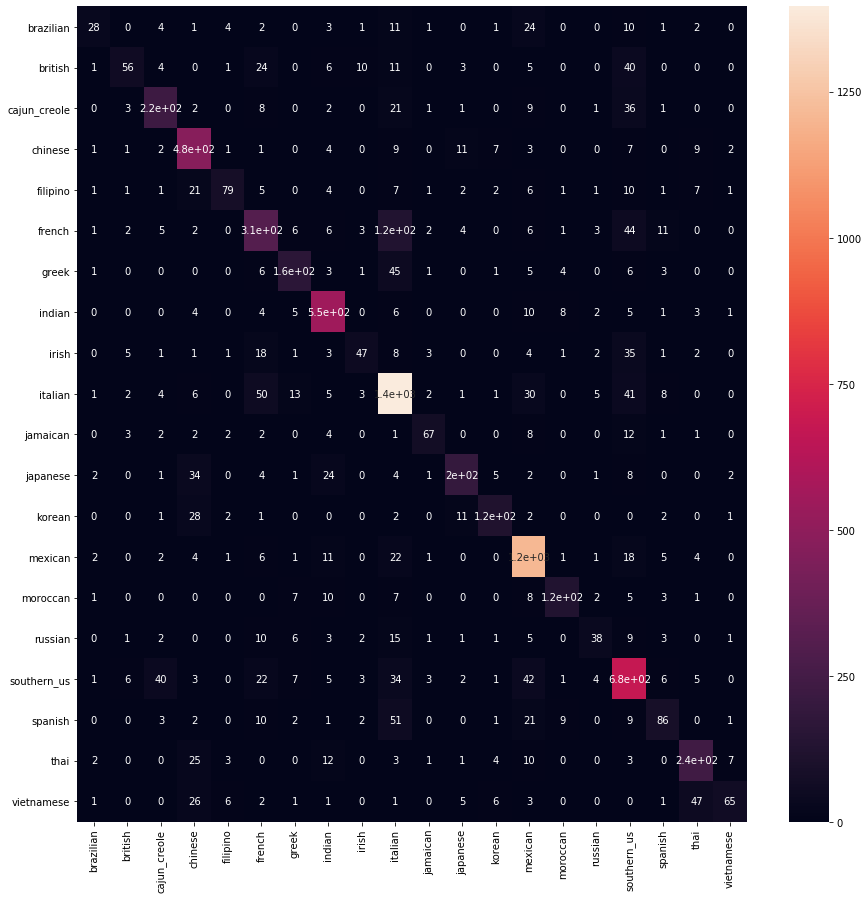

In [53]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(15,15))
sns.heatmap(pd.DataFrame(cm, index=encoder.classes_, 
                         columns=encoder.classes_,),
                         annot=True)

I am running out of time at this point. Let's recap the 3 tasks.

### 1) We want to predict the cuisine of a recipe given only its ingredients. 
Using sklearn's linearSVC, we are able to predict with 66% accuracy. Given more time, I will investigate a) further work with feature engineering such as varying the number of ingredients and minimum frequency, b) the use of cross validation, and c) the use of deep learning methods. 

Edit: After text preprocessing and using a SVM-based classifier trained with SGD, the testing accuracy went up from merely 60% to 77%. 

### 2) For each each major cuisine, what are the driving ingredients that characterize it?
This can be found with topic modelling techniques such as LDA (but it's unsupervised). we can also look at the trained model coefficients and see which ingredients have the largest weights for each cuisine. Here we see the top 5 ingredients for each cuisine.

In [58]:
def print_top5(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-5:]
        print("%12s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))

In [59]:
print_top5(vectorizer=vectorizer, clf=clf, class_labels=clf.classes_)

   brazilian: palm_oil aai manioc chocolate_sprinkle cachaca
     british: golden_syrup marmite beef_dripping suet stilton_cheese
cajun_creole: red_bean celery andouille_sausage creole_seasoning cajun_seasoning
     chinese: chinese_rice_wine corn_starch hoisin_sauce szechwan_peppercorn chinese_fivespice_powder
    filipino: peppercorn lumpia_skin calamansi calamansi_juice lumpia_wrapper
      french: nioise_olive swiss_cheese cognac gruyre_cheese gruyere_cheese
       greek: grape_leaf greek_yogurt greek_seasoning feta_cheese feta_cheese_crumbles
      indian: plain_yogurt ground_cardamom yoghurt curry_powder garam_masala
       irish: beef_brisket irish_bacon irish_cream_liqueur guinness_beer irish_whiskey
     italian: arborio_rice italian_seasoning marsala ricotta_cheese parmesan_cheese
    jamaican: allspice scotch_bonnet_chile ground_allspice jamaican_jerk_season thyme
    japanese: soba_noodle dashi nori sake mirin
      korean: beef_rib_short asian_pear sesame_seed kimchi gochu

### 3) How would you go about writing this guide for a few major cuisines?
Given the confusion matrix, we can see a few major cluster of cuisines that use similar ingredients, such as the south Asian (chinese, thai, vietnamese) and Mexican-Southern_US-Cajun_creole. I think tht this guide would start with clustering the remaining recipes into one of these bigger major cuisine groups, then within those groups, use the ingredients that are unique to certain cuisines to label them.